## Library

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import random
from collections import OrderedDict, ChainMap, Counter
from tqdm.asyncio import tqdm
import math
import matplotlib.pyplot as plt

# for reproducible results
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cpu')
# gpu
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
print(device)

cuda:0


## Data processing

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))]) # scale from [0,255] to [0,1] and make mean and std to 0.0 and 1.0 respectively
training_dataset = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data/mnist/', train=False, download=True, transform=transform)

In [3]:
# sort by labels
sorted_indices = torch.argsort(torch.Tensor(training_dataset.targets))
sorted_training_dataset = torch.utils.data.Subset(training_dataset, sorted_indices)

# partition data into shards
def prepare_datashards(num_clients, num_shards, strict=False):
    training_datashards = []

    shards = []
    # partition by class
    if strict:
        number_of_classes = len(sorted_training_dataset.dataset.classes)
        shards_per_class = num_shards // number_of_classes

        ptr = 0
        # for each class
        for label, size in sorted(Counter(sorted_training_dataset.dataset.targets.tolist()).items()):
            shard_size = math.ceil(size / shards_per_class)

            # for each shard
            for i in range(shards_per_class):
                shard = []
                # fill shard of shard_size
                for j in range(shard_size):
                    shard.append(sorted_training_dataset[ptr])
                    ptr += 1
                    # break for next class
                    if ptr >= len(sorted_training_dataset) or sorted_training_dataset[ptr][1] != label:
                        break
                shards.append(shard)

    # partition by size
    else:
        shard_size = len(sorted_training_dataset) // num_shards

        # for each shard
        for i in range(num_shards):
            shard = []
            # fill shard of shard_size
            for j in range(shard_size):
                shard.append(sorted_training_dataset[i * shard_size + j])
            shards.append(shard)
    
    # shuffled shard ids
    random.seed(seed)
    shard_ids = random.sample(list(range(num_shards)), num_shards)
    print("Shards order - {}".format(shard_ids))

    # for each client
    for k in range(num_clients):
        client_shards = []
        # number of shards per client
        shards_per_client = num_shards // num_clients
        for s in range(shards_per_client):
            id = shard_ids[k * shards_per_client + s]
            client_shards.append(shards[id])
        training_datashards.append(client_shards)

    return training_datashards

## Global

In [4]:
# clients training mode
PARALLEL_TRAINING = True

# clients and shards
num_clients = 100
num_shards = 200

# prepare training data
training_datashards = prepare_datashards(num_clients, num_shards)

Shards order - [163, 28, 6, 189, 70, 62, 57, 35, 188, 26, 173, 139, 22, 151, 108, 8, 7, 23, 55, 59, 129, 154, 197, 143, 50, 166, 191, 107, 56, 114, 150, 71, 1, 40, 185, 87, 168, 39, 181, 86, 190, 182, 97, 24, 91, 88, 67, 11, 117, 137, 31, 96, 20, 141, 75, 92, 49, 17, 152, 58, 74, 147, 180, 25, 157, 199, 116, 93, 41, 94, 90, 53, 68, 89, 119, 164, 82, 9, 77, 81, 21, 127, 132, 149, 138, 169, 48, 34, 120, 178, 134, 198, 124, 131, 98, 99, 183, 29, 4, 174, 51, 112, 184, 27, 72, 155, 100, 148, 83, 63, 175, 123, 140, 18, 33, 142, 133, 109, 118, 85, 196, 54, 79, 104, 46, 165, 84, 65, 179, 146, 177, 14, 19, 115, 78, 135, 176, 156, 38, 102, 80, 16, 192, 161, 0, 43, 145, 103, 95, 105, 113, 73, 106, 125, 52, 160, 144, 10, 60, 171, 172, 32, 195, 61, 69, 153, 36, 12, 122, 37, 194, 5, 110, 47, 162, 186, 126, 42, 15, 159, 3, 30, 130, 45, 167, 158, 76, 128, 170, 136, 44, 64, 2, 13, 121, 111, 193, 101, 187, 66]


## Model

In [5]:
class CNN(nn.Module):
    # https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html#specify-how-data-will-pass-through-your-model
    def __init__(self):
        super(CNN, self).__init__()
        # 5x5 convolution layer with 32 channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding='same')
        # 5x5 convolution layer with 64 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same')
        # fully connected layer with 512 units, in_features = channels * height * width from conv2
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)
        # Run max pooling over x
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten x with start_dim=1
        x = torch.flatten(x, start_dim=1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
num_params = sum(p.numel() for p in CNN().parameters())
print("Total number of parameters:", num_params)

Total number of parameters: 1663370


In [7]:
for p in CNN().parameters():
    print(p.shape)

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([512, 3136])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


## Client


In [8]:
class Client():
    def __init__(self, k, model, args):
        # inititalize client
        self.id = k
        self.model = model
        self.args = args

        # load dataset
        self.dataset = []
        self._load_dataset(k)
        self.training_loader = torch.utils.data.DataLoader(self.dataset, batch_size=self.args['B'], shuffle=True)

        # state_dict
        self.state_dict = self.model.state_dict()

    def _load_dataset(self, k):
        # load dataset
        for shard in training_datashards[k]:
            self.dataset += shard
        return

    def labels(self):
        return dict(Counter(data[1] for data in self.dataset))

    def size(self):
        return len(self.dataset)

    async def update(self):
        # load state_dict
        self.model.load_state_dict(self.state_dict)

        # Sets the module in training mode
        self.model.train(True)

        optimizer = optim.SGD(self.model.parameters(), lr=self.args['lr'])
        loss_fn = nn.CrossEntropyLoss()

        # https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
        for epoch in range(self.args['E']):
            for inputs, labels in self.training_loader:
                # Every data instance is an input + label pair
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero your gradients for every batch!
                optimizer.zero_grad()

                # Make predictions for this batch
                outputs = self.model(inputs)

                # Compute the loss and its gradients
                loss = loss_fn(outputs, labels)
                loss.backward()

                # Adjust learning weights
                optimizer.step()
        
        # save state_dict
        self.state_dict = self.model.state_dict()

        return { self.id: self.state_dict }

    def model_sync(self, state_dict):
        self.state_dict = state_dict

## Server

In [9]:
class Server():
    def __init__(self, args):
        self.model = CNN().to(device)
        # number of rounds of communication
        self.rounds = 0
        # client fraction C
        self.c = args['C']
        # client list
        self.clients = []
        # inititalize clients according to num_clients
        if PARALLEL_TRAINING:
            for k in range(num_clients):
                torch.manual_seed(seed)
                client_model = CNN().to(device)
                client = Client(k, client_model, args)
                self.clients.append(client)
        else:
            torch.manual_seed(seed)
            client_model = CNN().to(device)
            for k in range(num_clients):
                client = Client(k, client_model, args)
                self.clients.append(client)

    def _fed_avg(self, state_dicts):
        # total number of data
        len_total = 0
        for k in ChainMap(*state_dicts).keys():
            len_total += self.clients[k].size()

        dict = OrderedDict()
        # for each client's state_dict
        for k, state_dict in ChainMap(*state_dicts).items():
            # for each tensor param
            for param_tensor in self.model.state_dict().keys():
                # param = w0 * wf0 + w1 * wf1 + ... wk * wfk
                if param_tensor in dict:
                    dict[param_tensor] += state_dict[param_tensor] * (self.clients[k].size() / len_total)
                else:
                    dict[param_tensor] = state_dict[param_tensor] * (self.clients[k].size() / len_total)

        return dict

    def clients_info(self):
        for i, client in enumerate(self.clients):
            print("Client {} - {}".format(i, client.labels()))

    async def model_sync(self):
        selected_clients = self.clients

        # clients random selection
        if self.c < 1.0:
            # clients per round
            k = max(int(self.c * num_clients), 1)
            # client selection
            random.seed(self.rounds)
            selected_clients = random.sample(self.clients, k=k)
            client_ids = []
            for client in selected_clients:
                client_ids.append(client.id)
            print("Selected clients - {}".format(client_ids))

        state_dicts = []
        # for each selected client do client update
        if PARALLEL_TRAINING:
            state_dicts = await tqdm.gather(*[client.update() for client in selected_clients])
        else:
            for client in tqdm(selected_clients):
                state_dict = await client.update()
                state_dicts.append(state_dict)
        
        # update server weights
        avg_state_dict = self._fed_avg(state_dicts)
        self.model.load_state_dict(avg_state_dict)

        # sync with all clients
        for client in self.clients:
            client.model_sync(avg_state_dict)

        # increase rounds count
        self.rounds += 1

In [10]:
def test_model(model):
    # https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model#test-the-model-on-the-test-data
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    # Sets the module in evaluate mode
    model.eval()
    model.to(device)
    
    correct = 0
    loss = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Every data instance is an input + label pair
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Make predictions for this batch
            outputs = model(inputs)
            _, pred = torch.max(outputs, dim=1)
            total += labels.size(0)

            # Compute the loss and accuracy
            loss += loss_fn(outputs, labels).item()
            correct += (pred == labels).sum().item()

    loss /= total
    accuracy = correct / total

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        loss, correct, total, accuracy * 100))
    return accuracy, loss

In [11]:
async def execute(server, T, target_accuracy, es=None, min_delta=0.0, patience=0):
    _patience = patience

    # initial values
    record_round = 0
    best_round = 0
    best_accuracy = 0.0
    last_loss = None
    state_dict, accuracies, losses = [], [], []

    # loop until rounds
    while server.rounds < T:
        print("Round {}/{}".format(server.rounds + 1, T))

        # model sync
        await server.model_sync()
        
        # test accuracy
        accuracy, loss = test_model(server.model)

        if accuracy >= best_accuracy:
            # save best record
            best_accuracy = accuracy
            best_round = server.rounds

            if best_accuracy >= target_accuracy or server.rounds > T - 10:
                # save state_dict
                state_dict = server.model.state_dict()

        # statistics
        accuracies.append(accuracy)
        losses.append(loss)

        # early stopping
        if es == 'loss':
            if last_loss is None:
                last_loss = loss
                continue

            if last_loss - loss < min_delta:
                # break if patience equal to 0
                if patience == 0:
                    break
                else:
                    patience -= 1
            else:
                # reset patience and update last loss
                patience = _patience
                last_loss = loss

        # target accuracy reached
        if accuracy >= target_accuracy and record_round == 0:
            record_round = server.rounds

    if record_round > 0:
        print("Target accuracy reached at round: {}".format(record_round))
    print("Best round: {}, accuracy: {}".format(best_round, best_accuracy))

    return state_dict, accuracies, losses

## Execute

In [12]:
# model params
args = { 'C': 0.2, 'E': 5, 'B': 10 , 'lr': 0.08 }

# server
server = Server(args)

# data distribution
print("Training dataset - {}".format(dict(sorted(Counter(training_dataset.targets.tolist()).items()))))
server.clients_info()

Training dataset - {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Client 0 - {8: 300, 1: 300}
Client 1 - {0: 300, 9: 300}
Client 2 - {3: 577, 2: 23}
Client 3 - {2: 300, 1: 300}
Client 4 - {9: 300, 1: 300}
Client 5 - {8: 300, 6: 235, 7: 65}
Client 6 - {1: 300, 7: 300}
Client 7 - {5: 300, 0: 300}
Client 8 - {0: 300, 1: 300}
Client 9 - {2: 600}
Client 10 - {6: 300, 7: 300}
Client 11 - {9: 300, 7: 300}
Client 12 - {2: 300, 8: 300}
Client 13 - {9: 300, 5: 300}
Client 14 - {2: 300, 5: 300}
Client 15 - {7: 300, 3: 300}
Client 16 - {0: 300, 1: 300}
Client 17 - {9: 300, 4: 300}
Client 18 - {8: 300, 1: 300}
Client 19 - {9: 300, 4: 300}
Client 20 - {9: 600}
Client 21 - {4: 300, 1: 300}
Client 22 - {4: 600}
Client 23 - {3: 300, 0: 300}
Client 24 - {5: 300, 6: 300}
Client 25 - {1: 300, 4: 300}
Client 26 - {1: 300, 7: 300}
Client 27 - {3: 300, 4: 300}
Client 28 - {2: 300, 0: 300}
Client 29 - {7: 300, 2: 300}
Client 30 - {3: 300, 7: 300}
Client 31 - {8: 51,

In [13]:
# rounds and target accuracy
T = 300
target_accuracy = 0.99

state_dict, accuracies, losses = await execute(server, T, target_accuracy)

# save model to file
torch.save(state_dict, "cnn_state_dict.pth")

Round 1/300
Selected clients - [49, 97, 53, 5, 33, 65, 62, 51, 38, 61, 45, 74, 27, 64, 17, 36, 96, 12, 79, 32]


100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


Test set: Average loss: 0.2273, Accuracy: 1891/10000 (18.91%)
Round 2/300
Selected clients - [17, 72, 97, 8, 32, 15, 63, 57, 60, 83, 48, 26, 12, 62, 3, 49, 55, 77, 98, 0]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.1922, Accuracy: 4659/10000 (46.59%)
Round 3/300
Selected clients - [7, 11, 10, 46, 21, 94, 85, 39, 32, 77, 27, 4, 74, 87, 20, 55, 81, 50, 92, 65]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.1293, Accuracy: 5713/10000 (57.13%)
Round 4/300
Selected clients - [30, 75, 69, 16, 47, 77, 60, 80, 74, 8, 1, 33, 70, 29, 24, 91, 50, 81, 19, 66]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0988, Accuracy: 7602/10000 (76.02%)
Round 5/300
Selected clients - [30, 38, 13, 92, 50, 61, 19, 11, 8, 2, 51, 70, 37, 97, 7, 28, 66, 68, 46, 35]


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Test set: Average loss: 0.0952, Accuracy: 7309/10000 (73.09%)
Round 6/300
Selected clients - [79, 32, 94, 45, 88, 83, 67, 3, 59, 99, 31, 6, 20, 14, 47, 60, 48, 69, 13, 73]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0640, Accuracy: 7534/10000 (75.34%)
Round 7/300
Selected clients - [73, 10, 62, 97, 33, 4, 0, 18, 84, 75, 60, 94, 47, 40, 98, 2, 34, 25, 93, 52]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0357, Accuracy: 9225/10000 (92.25%)
Round 8/300
Selected clients - [41, 19, 50, 83, 6, 9, 68, 12, 46, 74, 7, 64, 27, 4, 11, 55, 53, 8, 30, 70]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0236, Accuracy: 9463/10000 (94.63%)
Round 9/300
Selected clients - [29, 47, 48, 16, 24, 90, 5, 10, 17, 31, 64, 26, 51, 82, 3, 58, 62, 49, 63, 73]


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Test set: Average loss: 0.0242, Accuracy: 9369/10000 (93.69%)
Round 10/300
Selected clients - [59, 78, 47, 34, 17, 23, 86, 0, 43, 64, 77, 10, 42, 70, 89, 5, 93, 48, 21, 90]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0221, Accuracy: 9320/10000 (93.20%)
Round 11/300
Selected clients - [73, 4, 54, 61, 1, 26, 59, 62, 35, 83, 20, 66, 41, 9, 31, 95, 46, 5, 53, 17]


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Test set: Average loss: 0.0160, Accuracy: 9567/10000 (95.67%)
Round 12/300
Selected clients - [57, 71, 99, 59, 65, 75, 24, 23, 60, 80, 78, 12, 38, 18, 11, 68, 88, 81, 5, 76]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0174, Accuracy: 9481/10000 (94.81%)
Round 13/300
Selected clients - [60, 34, 84, 67, 85, 44, 18, 48, 1, 47, 61, 35, 82, 58, 88, 76, 29, 71, 0, 79]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0159, Accuracy: 9496/10000 (94.96%)
Round 14/300
Selected clients - [33, 37, 87, 23, 83, 29, 85, 18, 28, 82, 93, 16, 9, 68, 27, 95, 3, 55, 77, 1]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0201, Accuracy: 9530/10000 (95.30%)
Round 15/300
Selected clients - [13, 78, 89, 96, 83, 67, 31, 34, 94, 32, 37, 93, 9, 84, 57, 38, 59, 87, 50, 99]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0134, Accuracy: 9617/10000 (96.17%)
Round 16/300
Selected clients - [26, 1, 66, 94, 4, 20, 30, 2, 7, 87, 18, 88, 47, 14, 43, 59, 90, 45, 35, 50]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0130, Accuracy: 9578/10000 (95.78%)
Round 17/300
Selected clients - [46, 60, 61, 36, 53, 29, 57, 0, 52, 84, 91, 33, 30, 81, 28, 1, 37, 38, 42, 85]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0107, Accuracy: 9667/10000 (96.67%)
Round 18/300
Selected clients - [66, 53, 38, 46, 37, 22, 98, 90, 69, 84, 35, 14, 3, 31, 49, 95, 32, 64, 40, 81]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0121, Accuracy: 9625/10000 (96.25%)
Round 19/300
Selected clients - [23, 15, 84, 57, 42, 30, 25, 62, 80, 63, 61, 37, 58, 33, 32, 88, 41, 66, 86, 97]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0104, Accuracy: 9742/10000 (97.42%)
Round 20/300
Selected clients - [86, 5, 66, 15, 65, 25, 50, 44, 67, 37, 74, 18, 76, 33, 13, 52, 41, 34, 98, 39]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0104, Accuracy: 9689/10000 (96.89%)
Round 21/300
Selected clients - [92, 87, 98, 19, 33, 86, 81, 12, 41, 73, 21, 3, 52, 9, 13, 16, 40, 60, 74, 57]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0102, Accuracy: 9672/10000 (96.72%)
Round 22/300
Selected clients - [21, 53, 88, 81, 36, 61, 27, 60, 65, 23, 64, 67, 30, 0, 1, 47, 74, 54, 8, 18]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0084, Accuracy: 9732/10000 (97.32%)
Round 23/300
Selected clients - [17, 31, 3, 78, 57, 23, 89, 15, 94, 83, 44, 10, 29, 34, 6, 40, 76, 22, 70, 87]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0083, Accuracy: 9748/10000 (97.48%)
Round 24/300
Selected clients - [99, 37, 10, 2, 75, 39, 54, 48, 67, 45, 16, 92, 24, 34, 56, 1, 28, 79, 58, 3]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0078, Accuracy: 9750/10000 (97.50%)
Round 25/300
Selected clients - [91, 49, 74, 23, 27, 21, 24, 85, 87, 11, 90, 96, 19, 36, 92, 98, 1, 56, 59, 81]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0104, Accuracy: 9673/10000 (96.73%)
Round 26/300
Selected clients - [48, 98, 1, 27, 39, 81, 60, 5, 96, 32, 4, 72, 54, 12, 75, 15, 73, 87, 93, 25]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0097, Accuracy: 9670/10000 (96.70%)
Round 27/300
Selected clients - [95, 25, 84, 26, 55, 76, 69, 7, 16, 99, 97, 61, 5, 93, 87, 79, 64, 21, 81, 54]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0064, Accuracy: 9781/10000 (97.81%)
Round 28/300
Selected clients - [83, 61, 89, 35, 36, 25, 9, 8, 32, 69, 42, 47, 51, 23, 31, 30, 62, 93, 81, 73]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0068, Accuracy: 9783/10000 (97.83%)
Round 29/300
Selected clients - [14, 95, 16, 69, 76, 91, 22, 28, 81, 59, 97, 53, 26, 27, 18, 50, 20, 77, 24, 25]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0068, Accuracy: 9767/10000 (97.67%)
Round 30/300
Selected clients - [70, 9, 44, 76, 77, 36, 11, 65, 50, 53, 2, 4, 13, 56, 83, 28, 10, 63, 42, 69]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0067, Accuracy: 9800/10000 (98.00%)
Round 31/300
Selected clients - [69, 37, 78, 3, 79, 83, 26, 32, 6, 50, 48, 82, 17, 10, 59, 0, 66, 31, 9, 20]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0073, Accuracy: 9783/10000 (97.83%)
Round 32/300
Selected clients - [1, 60, 14, 97, 50, 18, 87, 5, 17, 68, 29, 91, 96, 94, 4, 84, 7, 93, 57, 67]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0079, Accuracy: 9748/10000 (97.48%)
Round 33/300
Selected clients - [9, 27, 18, 38, 89, 30, 63, 3, 92, 4, 12, 41, 65, 42, 7, 66, 88, 60, 47, 76]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0057, Accuracy: 9809/10000 (98.09%)
Round 34/300
Selected clients - [73, 21, 80, 29, 35, 61, 83, 68, 67, 23, 78, 64, 41, 87, 56, 36, 86, 81, 9, 38]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0059, Accuracy: 9809/10000 (98.09%)
Round 35/300
Selected clients - [67, 45, 74, 3, 29, 49, 46, 8, 54, 39, 43, 12, 65, 19, 35, 44, 78, 0, 99, 96]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0059, Accuracy: 9809/10000 (98.09%)
Round 36/300
Selected clients - [70, 42, 96, 16, 95, 43, 19, 36, 55, 32, 72, 7, 67, 35, 83, 46, 91, 74, 12, 1]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0064, Accuracy: 9787/10000 (97.87%)
Round 37/300
Selected clients - [42, 7, 2, 36, 10, 0, 64, 80, 22, 31, 34, 93, 83, 55, 46, 71, 69, 9, 73, 52]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0057, Accuracy: 9807/10000 (98.07%)
Round 38/300
Selected clients - [87, 77, 11, 79, 85, 95, 81, 65, 4, 80, 47, 56, 67, 13, 58, 76, 36, 48, 94, 54]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0059, Accuracy: 9803/10000 (98.03%)
Round 39/300
Selected clients - [81, 53, 54, 96, 92, 13, 8, 46, 89, 59, 47, 5, 77, 85, 21, 75, 44, 41, 34, 90]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0058, Accuracy: 9809/10000 (98.09%)
Round 40/300
Selected clients - [26, 33, 49, 3, 24, 28, 50, 93, 72, 0, 82, 32, 86, 45, 90, 22, 37, 9, 46, 1]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0054, Accuracy: 9818/10000 (98.18%)
Round 41/300
Selected clients - [58, 74, 67, 4, 31, 36, 85, 81, 26, 16, 97, 44, 35, 95, 56, 3, 94, 7, 82, 25]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0050, Accuracy: 9835/10000 (98.35%)
Round 42/300
Selected clients - [48, 42, 29, 21, 49, 73, 88, 36, 70, 35, 93, 97, 1, 99, 31, 84, 2, 56, 19, 92]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0050, Accuracy: 9819/10000 (98.19%)
Round 43/300
Selected clients - [81, 14, 3, 94, 35, 31, 28, 17, 13, 86, 69, 11, 75, 54, 4, 27, 29, 64, 77, 71]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0051, Accuracy: 9837/10000 (98.37%)
Round 44/300
Selected clients - [4, 36, 89, 97, 18, 59, 47, 85, 12, 58, 76, 63, 77, 2, 65, 55, 73, 79, 70, 96]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0050, Accuracy: 9839/10000 (98.39%)
Round 45/300
Selected clients - [52, 66, 69, 89, 14, 22, 48, 28, 37, 3, 72, 1, 12, 20, 99, 65, 88, 38, 81, 75]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0055, Accuracy: 9816/10000 (98.16%)
Round 46/300
Selected clients - [34, 53, 62, 32, 10, 38, 43, 2, 9, 61, 1, 14, 36, 15, 39, 95, 83, 4, 79, 8]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0051, Accuracy: 9829/10000 (98.29%)
Round 47/300
Selected clients - [9, 51, 5, 75, 29, 81, 66, 19, 74, 68, 4, 3, 8, 40, 80, 6, 17, 70, 37, 67]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0049, Accuracy: 9842/10000 (98.42%)
Round 48/300
Selected clients - [45, 8, 55, 70, 58, 73, 43, 32, 65, 49, 50, 78, 5, 53, 84, 3, 13, 0, 33, 61]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0049, Accuracy: 9842/10000 (98.42%)
Round 49/300
Selected clients - [70, 40, 16, 71, 91, 68, 38, 64, 24, 97, 55, 21, 19, 84, 13, 63, 83, 28, 27, 65]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0047, Accuracy: 9845/10000 (98.45%)
Round 50/300
Selected clients - [8, 44, 52, 14, 41, 96, 70, 65, 6, 87, 5, 97, 94, 35, 19, 58, 93, 80, 69, 64]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0049, Accuracy: 9842/10000 (98.42%)
Round 51/300
Selected clients - [63, 34, 46, 81, 31, 88, 60, 98, 42, 10, 68, 40, 28, 86, 71, 19, 44, 12, 24, 8]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0048, Accuracy: 9844/10000 (98.44%)
Round 52/300
Selected clients - [31, 64, 70, 20, 29, 32, 50, 59, 93, 89, 67, 80, 43, 75, 84, 46, 49, 35, 51, 0]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0053, Accuracy: 9839/10000 (98.39%)
Round 53/300
Selected clients - [34, 6, 92, 65, 61, 47, 52, 4, 17, 20, 23, 44, 56, 80, 0, 69, 49, 1, 30, 8]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0050, Accuracy: 9825/10000 (98.25%)
Round 54/300
Selected clients - [78, 27, 58, 64, 91, 61, 66, 46, 93, 3, 4, 21, 44, 95, 16, 33, 7, 6, 29, 56]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0044, Accuracy: 9847/10000 (98.47%)
Round 55/300
Selected clients - [17, 56, 71, 38, 61, 62, 48, 28, 57, 42, 73, 93, 26, 92, 25, 7, 63, 70, 76, 11]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0043, Accuracy: 9852/10000 (98.52%)
Round 56/300
Selected clients - [11, 25, 19, 94, 38, 10, 95, 23, 45, 92, 84, 60, 69, 49, 64, 51, 40, 54, 68, 98]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0041, Accuracy: 9862/10000 (98.62%)
Round 57/300
Selected clients - [71, 1, 60, 83, 66, 38, 98, 69, 53, 90, 29, 12, 47, 79, 8, 43, 82, 32, 73, 26]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0045, Accuracy: 9855/10000 (98.55%)
Round 58/300
Selected clients - [5, 47, 75, 77, 2, 28, 65, 41, 61, 37, 55, 81, 48, 94, 21, 66, 50, 13, 83, 92]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0045, Accuracy: 9854/10000 (98.54%)
Round 59/300
Selected clients - [74, 25, 26, 94, 82, 5, 24, 57, 51, 45, 36, 33, 78, 53, 13, 1, 62, 27, 60, 96]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0038, Accuracy: 9864/10000 (98.64%)
Round 60/300
Selected clients - [28, 10, 83, 58, 2, 17, 38, 91, 87, 79, 1, 62, 48, 68, 97, 20, 93, 74, 43, 85]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0040, Accuracy: 9863/10000 (98.63%)
Round 61/300
Selected clients - [39, 36, 73, 19, 33, 29, 61, 59, 42, 5, 11, 85, 23, 49, 30, 81, 1, 52, 92, 21]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0043, Accuracy: 9847/10000 (98.47%)
Round 62/300
Selected clients - [63, 23, 71, 27, 41, 37, 88, 3, 62, 45, 8, 51, 59, 42, 21, 80, 0, 64, 11, 81]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0050, Accuracy: 9838/10000 (98.38%)
Round 63/300
Selected clients - [73, 22, 8, 30, 59, 39, 85, 45, 21, 65, 23, 20, 0, 33, 81, 15, 3, 60, 66, 2]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0043, Accuracy: 9853/10000 (98.53%)
Round 64/300
Selected clients - [56, 37, 32, 61, 84, 11, 49, 95, 10, 9, 25, 80, 39, 78, 7, 28, 16, 42, 30, 35]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0040, Accuracy: 9855/10000 (98.55%)
Round 65/300
Selected clients - [60, 15, 80, 78, 51, 68, 87, 2, 26, 34, 90, 97, 25, 89, 99, 83, 18, 10, 53, 56]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0044, Accuracy: 9846/10000 (98.46%)
Round 66/300
Selected clients - [53, 36, 65, 28, 56, 58, 67, 70, 43, 81, 55, 9, 71, 59, 33, 25, 83, 60, 79, 88]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0037, Accuracy: 9873/10000 (98.73%)
Round 67/300
Selected clients - [9, 39, 55, 31, 57, 37, 32, 71, 12, 95, 63, 23, 59, 66, 16, 91, 8, 46, 93, 21]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0042, Accuracy: 9856/10000 (98.56%)
Round 68/300
Selected clients - [9, 14, 98, 52, 59, 53, 34, 76, 54, 62, 79, 35, 26, 82, 5, 85, 22, 36, 4, 20]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0039, Accuracy: 9858/10000 (98.58%)
Round 69/300
Selected clients - [94, 59, 88, 95, 64, 14, 77, 74, 31, 55, 60, 33, 92, 86, 42, 56, 70, 46, 21, 83]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0038, Accuracy: 9866/10000 (98.66%)
Round 70/300
Selected clients - [87, 4, 12, 21, 8, 77, 44, 41, 70, 53, 59, 54, 72, 56, 66, 71, 18, 52, 50, 36]


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Test set: Average loss: 0.0036, Accuracy: 9861/10000 (98.61%)
Round 71/300
Selected clients - [15, 37, 89, 58, 57, 17, 41, 13, 19, 86, 76, 27, 91, 85, 52, 48, 30, 51, 83, 9]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0039, Accuracy: 9857/10000 (98.57%)
Round 72/300
Selected clients - [41, 65, 79, 1, 33, 19, 96, 25, 11, 7, 76, 24, 64, 3, 88, 67, 46, 58, 97, 16]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0039, Accuracy: 9867/10000 (98.67%)
Round 73/300
Selected clients - [9, 76, 94, 23, 44, 89, 69, 79, 47, 39, 91, 87, 16, 88, 43, 29, 48, 18, 81, 3]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0041, Accuracy: 9855/10000 (98.55%)
Round 74/300
Selected clients - [35, 15, 64, 61, 72, 23, 59, 38, 75, 9, 62, 51, 66, 25, 57, 14, 2, 32, 52, 99]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0040, Accuracy: 9854/10000 (98.54%)
Round 75/300
Selected clients - [78, 65, 14, 40, 15, 39, 23, 27, 44, 56, 58, 67, 35, 57, 21, 64, 79, 0, 88, 5]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0039, Accuracy: 9860/10000 (98.60%)
Round 76/300
Selected clients - [57, 74, 55, 58, 5, 93, 98, 65, 86, 85, 60, 88, 44, 12, 40, 10, 96, 32, 35, 63]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0036, Accuracy: 9870/10000 (98.70%)
Round 77/300
Selected clients - [47, 59, 49, 25, 38, 6, 53, 30, 36, 96, 56, 62, 29, 10, 42, 68, 7, 0, 84, 52]


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Test set: Average loss: 0.0043, Accuracy: 9855/10000 (98.55%)
Round 78/300
Selected clients - [32, 41, 25, 30, 24, 14, 37, 60, 71, 78, 18, 80, 84, 64, 0, 35, 3, 63, 22, 49]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0036, Accuracy: 9877/10000 (98.77%)
Round 79/300
Selected clients - [24, 12, 38, 85, 93, 32, 95, 54, 4, 83, 18, 51, 98, 84, 89, 60, 48, 69, 1, 30]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0037, Accuracy: 9867/10000 (98.67%)
Round 80/300
Selected clients - [18, 56, 44, 76, 20, 30, 31, 92, 88, 63, 19, 8, 3, 25, 14, 62, 91, 39, 22, 52]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0036, Accuracy: 9870/10000 (98.70%)
Round 81/300
Selected clients - [34, 50, 69, 90, 53, 47, 46, 68, 51, 3, 70, 97, 49, 28, 79, 6, 30, 21, 67, 72]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0038, Accuracy: 9865/10000 (98.65%)
Round 82/300
Selected clients - [64, 58, 43, 71, 68, 49, 61, 2, 20, 19, 57, 86, 97, 77, 0, 40, 36, 92, 45, 28]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0035, Accuracy: 9876/10000 (98.76%)
Round 83/300
Selected clients - [18, 98, 62, 64, 37, 22, 21, 87, 33, 20, 97, 4, 55, 60, 74, 12, 25, 39, 71, 17]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0042, Accuracy: 9871/10000 (98.71%)
Round 84/300
Selected clients - [63, 58, 11, 16, 48, 4, 6, 83, 27, 24, 22, 39, 10, 52, 19, 45, 38, 71, 25, 60]


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Test set: Average loss: 0.0039, Accuracy: 9869/10000 (98.69%)
Round 85/300
Selected clients - [93, 36, 99, 4, 62, 0, 66, 84, 40, 25, 58, 63, 70, 96, 94, 46, 77, 19, 69, 91]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0040, Accuracy: 9871/10000 (98.71%)
Round 86/300
Selected clients - [25, 89, 78, 13, 41, 24, 28, 59, 99, 98, 44, 74, 87, 48, 68, 75, 76, 73, 77, 55]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0038, Accuracy: 9868/10000 (98.68%)
Round 87/300
Selected clients - [99, 3, 71, 40, 95, 1, 98, 8, 90, 64, 94, 80, 38, 92, 48, 13, 12, 52, 58, 0]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0038, Accuracy: 9867/10000 (98.67%)
Round 88/300
Selected clients - [18, 94, 24, 69, 13, 35, 96, 42, 82, 90, 41, 15, 46, 1, 49, 11, 63, 65, 78, 89]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0039, Accuracy: 9860/10000 (98.60%)
Round 89/300
Selected clients - [50, 24, 42, 23, 80, 1, 67, 98, 89, 43, 87, 59, 17, 28, 15, 88, 77, 22, 56, 52]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0034, Accuracy: 9871/10000 (98.71%)
Round 90/300
Selected clients - [10, 98, 77, 90, 33, 17, 44, 8, 19, 53, 42, 26, 38, 88, 87, 9, 73, 21, 59, 79]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0033, Accuracy: 9887/10000 (98.87%)
Round 91/300
Selected clients - [26, 91, 11, 61, 84, 73, 75, 39, 81, 45, 57, 33, 62, 34, 47, 9, 69, 93, 18, 5]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0035, Accuracy: 9883/10000 (98.83%)
Round 92/300
Selected clients - [10, 75, 22, 87, 86, 20, 51, 58, 95, 56, 59, 32, 31, 24, 77, 47, 62, 27, 49, 96]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0037, Accuracy: 9881/10000 (98.81%)
Round 93/300
Selected clients - [53, 66, 72, 70, 71, 75, 34, 86, 97, 12, 60, 20, 9, 73, 85, 80, 43, 7, 5, 3]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0038, Accuracy: 9866/10000 (98.66%)
Round 94/300
Selected clients - [63, 72, 92, 45, 14, 11, 18, 22, 50, 15, 20, 74, 4, 79, 70, 86, 47, 51, 83, 9]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9873/10000 (98.73%)
Round 95/300
Selected clients - [69, 23, 15, 35, 38, 55, 2, 87, 63, 47, 39, 54, 76, 68, 1, 95, 45, 58, 44, 27]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0036, Accuracy: 9877/10000 (98.77%)
Round 96/300
Selected clients - [97, 68, 65, 94, 69, 16, 63, 3, 17, 1, 76, 10, 80, 35, 24, 5, 72, 92, 67, 77]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0033, Accuracy: 9882/10000 (98.82%)
Round 97/300
Selected clients - [47, 40, 86, 50, 26, 12, 43, 97, 5, 89, 2, 21, 52, 82, 11, 32, 45, 35, 16, 64]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0031, Accuracy: 9886/10000 (98.86%)
Round 98/300
Selected clients - [24, 54, 47, 6, 73, 2, 71, 99, 5, 95, 34, 3, 9, 81, 56, 60, 86, 14, 40, 31]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0032, Accuracy: 9882/10000 (98.82%)
Round 99/300
Selected clients - [45, 73, 5, 53, 7, 60, 36, 93, 86, 71, 8, 63, 25, 50, 4, 83, 90, 97, 46, 0]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0033, Accuracy: 9885/10000 (98.85%)
Round 100/300
Selected clients - [51, 48, 25, 76, 22, 29, 31, 17, 97, 11, 32, 93, 49, 67, 87, 89, 68, 79, 62, 53]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9883/10000 (98.83%)
Round 101/300
Selected clients - [18, 58, 98, 22, 90, 50, 93, 44, 55, 64, 14, 68, 15, 10, 94, 33, 6, 84, 82, 26]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0032, Accuracy: 9890/10000 (98.90%)
Round 102/300
Selected clients - [74, 24, 69, 45, 59, 6, 84, 64, 27, 77, 28, 36, 62, 88, 42, 56, 9, 32, 20, 11]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0029, Accuracy: 9904/10000 (99.04%)
Round 103/300
Selected clients - [18, 86, 78, 45, 21, 70, 91, 84, 77, 23, 49, 37, 79, 54, 72, 74, 5, 92, 67, 69]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0031, Accuracy: 9886/10000 (98.86%)
Round 104/300
Selected clients - [91, 58, 92, 89, 94, 27, 88, 9, 77, 15, 83, 48, 59, 43, 86, 62, 10, 16, 28, 74]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0033, Accuracy: 9885/10000 (98.85%)
Round 105/300
Selected clients - [2, 25, 93, 98, 29, 50, 42, 0, 91, 16, 21, 13, 18, 15, 9, 83, 96, 47, 82, 7]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0036, Accuracy: 9868/10000 (98.68%)
Round 106/300
Selected clients - [75, 44, 74, 13, 0, 39, 67, 98, 73, 42, 37, 20, 21, 96, 18, 12, 84, 50, 55, 78]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0035, Accuracy: 9881/10000 (98.81%)
Round 107/300
Selected clients - [90, 61, 2, 71, 67, 60, 7, 33, 8, 24, 63, 46, 55, 57, 94, 83, 36, 88, 28, 95]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0034, Accuracy: 9879/10000 (98.79%)
Round 108/300
Selected clients - [31, 79, 74, 98, 93, 84, 54, 61, 97, 39, 17, 69, 96, 15, 32, 37, 76, 4, 90, 35]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0034, Accuracy: 9877/10000 (98.77%)
Round 109/300
Selected clients - [16, 91, 10, 84, 49, 93, 35, 48, 25, 38, 27, 23, 40, 24, 14, 71, 54, 13, 68, 41]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0033, Accuracy: 9880/10000 (98.80%)
Round 110/300
Selected clients - [35, 29, 58, 57, 70, 7, 12, 64, 63, 38, 72, 66, 10, 30, 54, 85, 21, 39, 93, 40]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0036, Accuracy: 9873/10000 (98.73%)
Round 111/300
Selected clients - [49, 76, 31, 52, 61, 91, 35, 81, 69, 88, 9, 53, 64, 40, 95, 5, 14, 65, 10, 19]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 112/300
Selected clients - [27, 40, 63, 24, 50, 53, 78, 21, 80, 89, 71, 29, 23, 85, 59, 49, 91, 35, 48, 28]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0031, Accuracy: 9882/10000 (98.82%)
Round 113/300
Selected clients - [61, 85, 74, 79, 38, 89, 59, 53, 96, 84, 20, 46, 28, 67, 58, 3, 49, 76, 30, 93]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0031, Accuracy: 9891/10000 (98.91%)
Round 114/300
Selected clients - [3, 83, 92, 35, 2, 61, 70, 44, 30, 55, 8, 38, 16, 76, 63, 36, 43, 50, 24, 59]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9873/10000 (98.73%)
Round 115/300
Selected clients - [30, 72, 12, 43, 85, 31, 80, 79, 6, 19, 66, 67, 86, 37, 74, 8, 68, 47, 90, 13]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0035, Accuracy: 9872/10000 (98.72%)
Round 116/300
Selected clients - [36, 25, 99, 14, 68, 42, 96, 70, 37, 86, 81, 87, 43, 61, 7, 18, 19, 5, 22, 62]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0036, Accuracy: 9867/10000 (98.67%)
Round 117/300
Selected clients - [95, 76, 69, 92, 38, 1, 96, 82, 15, 94, 16, 61, 31, 35, 52, 74, 54, 73, 9, 57]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0033, Accuracy: 9881/10000 (98.81%)
Round 118/300
Selected clients - [30, 23, 21, 26, 51, 20, 71, 52, 89, 15, 91, 67, 72, 42, 44, 58, 83, 4, 16, 47]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0030, Accuracy: 9894/10000 (98.94%)
Round 119/300
Selected clients - [91, 80, 23, 39, 12, 89, 46, 37, 98, 2, 38, 42, 3, 77, 63, 65, 43, 72, 66, 18]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9869/10000 (98.69%)
Round 120/300
Selected clients - [36, 23, 94, 68, 85, 96, 70, 55, 13, 10, 54, 80, 31, 22, 32, 35, 26, 60, 74, 2]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0030, Accuracy: 9887/10000 (98.87%)
Round 121/300
Selected clients - [65, 31, 24, 81, 93, 75, 85, 59, 11, 40, 27, 28, 32, 92, 41, 47, 94, 20, 13, 90]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0038, Accuracy: 9870/10000 (98.70%)
Round 122/300
Selected clients - [11, 27, 74, 50, 80, 22, 78, 66, 42, 36, 23, 81, 54, 7, 86, 92, 77, 55, 16, 3]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0033, Accuracy: 9871/10000 (98.71%)
Round 123/300
Selected clients - [65, 27, 76, 38, 9, 93, 46, 97, 28, 58, 85, 75, 20, 13, 57, 91, 30, 71, 50, 48]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0036, Accuracy: 9881/10000 (98.81%)
Round 124/300
Selected clients - [6, 34, 11, 98, 52, 13, 4, 48, 68, 71, 42, 43, 20, 17, 89, 31, 0, 55, 99, 76]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0035, Accuracy: 9887/10000 (98.87%)
Round 125/300
Selected clients - [35, 70, 0, 22, 7, 53, 46, 4, 40, 21, 50, 39, 2, 69, 60, 78, 54, 29, 27, 12]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9876/10000 (98.76%)
Round 126/300
Selected clients - [31, 28, 76, 38, 72, 94, 23, 44, 19, 77, 39, 78, 80, 0, 9, 90, 81, 60, 64, 85]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0029, Accuracy: 9892/10000 (98.92%)
Round 127/300
Selected clients - [73, 7, 76, 58, 31, 82, 22, 60, 29, 20, 86, 17, 80, 62, 11, 94, 37, 68, 18, 45]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9892/10000 (98.92%)
Round 128/300
Selected clients - [5, 79, 74, 72, 12, 3, 34, 25, 52, 29, 38, 86, 85, 39, 48, 7, 40, 37, 68, 90]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0032, Accuracy: 9876/10000 (98.76%)
Round 129/300
Selected clients - [30, 51, 65, 46, 17, 61, 3, 19, 40, 81, 69, 32, 80, 85, 73, 91, 71, 38, 8, 99]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0034, Accuracy: 9880/10000 (98.80%)
Round 130/300
Selected clients - [75, 66, 34, 5, 88, 51, 80, 28, 42, 29, 14, 90, 70, 19, 17, 86, 35, 72, 61, 93]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0033, Accuracy: 9877/10000 (98.77%)
Round 131/300
Selected clients - [66, 54, 34, 94, 84, 56, 82, 58, 2, 45, 30, 74, 43, 28, 67, 85, 92, 13, 71, 87]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9890/10000 (98.90%)
Round 132/300
Selected clients - [40, 47, 98, 65, 11, 50, 36, 2, 49, 99, 15, 44, 72, 76, 12, 90, 21, 28, 89, 88]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9888/10000 (98.88%)
Round 133/300
Selected clients - [52, 19, 7, 21, 5, 39, 15, 99, 69, 3, 31, 57, 33, 25, 84, 73, 51, 88, 98, 63]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0032, Accuracy: 9889/10000 (98.89%)
Round 134/300
Selected clients - [63, 45, 61, 41, 98, 78, 43, 69, 88, 79, 94, 90, 4, 95, 10, 36, 84, 33, 27, 0]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0031, Accuracy: 9891/10000 (98.91%)
Round 135/300
Selected clients - [61, 66, 25, 92, 71, 95, 81, 16, 3, 83, 97, 62, 14, 49, 28, 31, 76, 69, 58, 13]


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Test set: Average loss: 0.0037, Accuracy: 9872/10000 (98.72%)
Round 136/300
Selected clients - [85, 47, 80, 82, 74, 35, 62, 37, 90, 15, 57, 36, 1, 75, 19, 81, 33, 46, 44, 39]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0033, Accuracy: 9881/10000 (98.81%)
Round 137/300
Selected clients - [73, 54, 67, 7, 55, 63, 97, 25, 89, 17, 21, 81, 5, 20, 90, 77, 6, 24, 35, 79]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9893/10000 (98.93%)
Round 138/300
Selected clients - [9, 23, 52, 41, 24, 29, 62, 44, 1, 51, 65, 50, 67, 60, 17, 54, 66, 42, 0, 78]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0031, Accuracy: 9896/10000 (98.96%)
Round 139/300
Selected clients - [24, 48, 57, 89, 38, 26, 66, 34, 31, 23, 18, 56, 21, 43, 95, 91, 98, 10, 62, 69]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0032, Accuracy: 9890/10000 (98.90%)
Round 140/300
Selected clients - [0, 88, 78, 68, 77, 84, 38, 95, 70, 67, 43, 97, 35, 44, 74, 96, 19, 34, 29, 72]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9896/10000 (98.96%)
Round 141/300
Selected clients - [98, 12, 3, 34, 2, 68, 93, 6, 86, 92, 28, 1, 65, 24, 90, 48, 81, 49, 39, 22]


100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Test set: Average loss: 0.0032, Accuracy: 9889/10000 (98.89%)
Round 142/300
Selected clients - [66, 99, 3, 74, 60, 22, 73, 89, 59, 0, 34, 83, 71, 1, 87, 43, 52, 30, 65, 44]


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Test set: Average loss: 0.0032, Accuracy: 9882/10000 (98.82%)
Round 143/300
Selected clients - [74, 88, 87, 81, 62, 21, 36, 44, 45, 33, 4, 12, 37, 73, 71, 26, 77, 68, 60, 31]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0031, Accuracy: 9892/10000 (98.92%)
Round 144/300
Selected clients - [23, 5, 2, 28, 18, 31, 10, 93, 52, 63, 17, 73, 16, 97, 11, 75, 37, 55, 12, 35]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9893/10000 (98.93%)
Round 145/300
Selected clients - [57, 4, 58, 10, 92, 21, 50, 11, 84, 52, 63, 75, 30, 59, 87, 17, 28, 53, 15, 64]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0033, Accuracy: 9889/10000 (98.89%)
Round 146/300
Selected clients - [96, 54, 66, 0, 56, 3, 84, 41, 93, 83, 87, 92, 60, 72, 65, 35, 14, 33, 23, 7]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 147/300
Selected clients - [17, 79, 42, 98, 8, 20, 72, 36, 10, 44, 5, 27, 84, 52, 39, 68, 90, 54, 19, 9]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9887/10000 (98.87%)
Round 148/300
Selected clients - [77, 82, 19, 50, 56, 78, 57, 23, 80, 94, 39, 53, 58, 91, 13, 59, 45, 8, 44, 43]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0029, Accuracy: 9899/10000 (98.99%)
Round 149/300
Selected clients - [51, 89, 81, 4, 86, 44, 36, 34, 13, 24, 63, 80, 9, 32, 68, 84, 73, 28, 53, 40]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0029, Accuracy: 9896/10000 (98.96%)
Round 150/300
Selected clients - [9, 12, 32, 48, 17, 7, 2, 22, 73, 5, 51, 6, 38, 24, 63, 8, 49, 11, 20, 4]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 151/300
Selected clients - [41, 51, 24, 29, 38, 61, 18, 20, 53, 11, 95, 37, 42, 36, 94, 56, 96, 50, 6, 17]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 9901/10000 (99.01%)
Round 152/300
Selected clients - [90, 52, 91, 80, 92, 26, 45, 36, 47, 73, 14, 59, 62, 9, 58, 13, 51, 93, 85, 23]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0031, Accuracy: 9891/10000 (98.91%)
Round 153/300
Selected clients - [96, 50, 80, 18, 48, 25, 11, 79, 2, 15, 14, 3, 44, 97, 62, 77, 22, 58, 31, 30]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9893/10000 (98.93%)
Round 154/300
Selected clients - [62, 9, 4, 33, 90, 53, 74, 72, 76, 71, 40, 54, 31, 65, 84, 26, 98, 28, 77, 83]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0033, Accuracy: 9888/10000 (98.88%)
Round 155/300
Selected clients - [26, 48, 62, 56, 65, 0, 57, 33, 50, 54, 83, 81, 74, 88, 6, 90, 97, 67, 7, 49]


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Test set: Average loss: 0.0033, Accuracy: 9883/10000 (98.83%)
Round 156/300
Selected clients - [74, 64, 69, 36, 87, 99, 53, 68, 35, 24, 83, 7, 73, 3, 67, 11, 22, 30, 81, 12]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0031, Accuracy: 9892/10000 (98.92%)
Round 157/300
Selected clients - [62, 53, 94, 31, 98, 45, 19, 28, 20, 17, 95, 71, 57, 48, 42, 10, 1, 56, 4, 68]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0031, Accuracy: 9897/10000 (98.97%)
Round 158/300
Selected clients - [78, 62, 28, 20, 2, 3, 44, 29, 40, 17, 11, 22, 94, 13, 14, 88, 92, 50, 52, 48]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9896/10000 (98.96%)
Round 159/300
Selected clients - [87, 28, 13, 7, 53, 72, 98, 42, 97, 81, 59, 5, 8, 14, 0, 71, 36, 6, 10, 77]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0030, Accuracy: 9898/10000 (98.98%)
Round 160/300
Selected clients - [50, 21, 86, 57, 31, 66, 25, 79, 24, 2, 96, 91, 62, 48, 4, 34, 85, 49, 28, 60]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0034, Accuracy: 9885/10000 (98.85%)
Round 161/300
Selected clients - [15, 64, 43, 51, 22, 75, 44, 91, 66, 63, 68, 27, 94, 54, 60, 1, 35, 42, 6, 29]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 9900/10000 (99.00%)
Round 162/300
Selected clients - [66, 26, 70, 21, 29, 81, 75, 61, 4, 96, 89, 93, 62, 6, 58, 90, 7, 79, 9, 76]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0031, Accuracy: 9884/10000 (98.84%)
Round 163/300
Selected clients - [6, 88, 80, 26, 64, 25, 52, 63, 98, 78, 37, 57, 58, 3, 23, 15, 53, 40, 82, 71]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0032, Accuracy: 9894/10000 (98.94%)
Round 164/300
Selected clients - [69, 79, 58, 74, 22, 63, 36, 27, 45, 26, 46, 17, 18, 78, 7, 88, 8, 43, 19, 93]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0033, Accuracy: 9885/10000 (98.85%)
Round 165/300
Selected clients - [12, 94, 38, 32, 59, 62, 77, 49, 15, 10, 53, 50, 0, 75, 24, 19, 39, 40, 82, 14]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0031, Accuracy: 9889/10000 (98.89%)
Round 166/300
Selected clients - [2, 7, 91, 55, 9, 63, 29, 22, 54, 86, 40, 74, 61, 25, 8, 53, 87, 16, 77, 52]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0032, Accuracy: 9878/10000 (98.78%)
Round 167/300
Selected clients - [22, 80, 77, 52, 54, 1, 41, 4, 62, 95, 72, 47, 37, 86, 25, 21, 94, 63, 12, 24]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0032, Accuracy: 9892/10000 (98.92%)
Round 168/300
Selected clients - [29, 11, 42, 54, 41, 98, 94, 92, 10, 95, 66, 0, 55, 78, 96, 63, 31, 7, 90, 14]


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Test set: Average loss: 0.0030, Accuracy: 9897/10000 (98.97%)
Round 169/300
Selected clients - [95, 14, 66, 47, 48, 23, 28, 68, 24, 25, 69, 65, 96, 63, 77, 27, 78, 85, 49, 53]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0033, Accuracy: 9879/10000 (98.79%)
Round 170/300
Selected clients - [32, 66, 79, 22, 71, 65, 15, 67, 44, 96, 68, 34, 60, 72, 26, 9, 77, 0, 16, 89]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9896/10000 (98.96%)
Round 171/300
Selected clients - [44, 75, 40, 11, 31, 41, 33, 74, 15, 27, 1, 49, 64, 38, 73, 63, 66, 0, 23, 58]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0032, Accuracy: 9885/10000 (98.85%)
Round 172/300
Selected clients - [71, 49, 52, 15, 75, 59, 86, 22, 48, 39, 41, 23, 17, 97, 29, 18, 79, 31, 24, 13]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9897/10000 (98.97%)
Round 173/300
Selected clients - [45, 24, 27, 38, 94, 6, 50, 59, 71, 56, 26, 73, 89, 12, 54, 0, 67, 17, 28, 34]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 9899/10000 (98.99%)
Round 174/300
Selected clients - [41, 62, 85, 99, 92, 65, 76, 46, 31, 52, 91, 0, 44, 89, 19, 94, 57, 58, 80, 87]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 175/300
Selected clients - [0, 56, 3, 63, 46, 8, 28, 30, 13, 95, 43, 55, 83, 47, 86, 72, 11, 87, 41, 89]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9895/10000 (98.95%)
Round 176/300
Selected clients - [56, 30, 6, 92, 73, 88, 64, 24, 32, 76, 9, 63, 65, 62, 58, 99, 4, 35, 96, 95]


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Test set: Average loss: 0.0030, Accuracy: 9903/10000 (99.03%)
Round 177/300
Selected clients - [3, 7, 98, 28, 99, 14, 49, 81, 40, 80, 83, 73, 61, 12, 0, 39, 78, 45, 60, 33]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0031, Accuracy: 9898/10000 (98.98%)
Round 178/300
Selected clients - [27, 63, 53, 74, 24, 90, 51, 5, 54, 82, 76, 93, 38, 94, 35, 11, 15, 13, 70, 88]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0034, Accuracy: 9896/10000 (98.96%)
Round 179/300
Selected clients - [14, 71, 59, 82, 30, 96, 43, 93, 61, 36, 23, 10, 57, 99, 70, 28, 35, 98, 21, 66]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0033, Accuracy: 9888/10000 (98.88%)
Round 180/300
Selected clients - [25, 15, 8, 7, 66, 38, 56, 6, 74, 32, 28, 72, 31, 40, 70, 63, 93, 16, 42, 20]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0033, Accuracy: 9893/10000 (98.93%)
Round 181/300
Selected clients - [18, 10, 86, 1, 79, 33, 15, 75, 64, 57, 31, 76, 4, 17, 0, 83, 3, 24, 14, 23]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0030, Accuracy: 9890/10000 (98.90%)
Round 182/300
Selected clients - [74, 89, 13, 7, 42, 43, 24, 96, 39, 29, 57, 58, 95, 31, 8, 28, 3, 98, 46, 35]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0032, Accuracy: 9887/10000 (98.87%)
Round 183/300
Selected clients - [57, 45, 29, 40, 44, 36, 9, 91, 34, 4, 80, 64, 59, 88, 35, 11, 27, 47, 97, 3]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9897/10000 (98.97%)
Round 184/300
Selected clients - [13, 11, 95, 0, 45, 38, 28, 66, 1, 82, 4, 9, 54, 79, 75, 89, 81, 29, 68, 91]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 9901/10000 (99.01%)
Round 185/300
Selected clients - [35, 0, 30, 88, 89, 41, 42, 43, 92, 79, 68, 26, 57, 74, 85, 1, 16, 65, 22, 45]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 186/300
Selected clients - [14, 19, 38, 75, 62, 60, 95, 51, 22, 0, 74, 99, 30, 90, 33, 55, 68, 3, 81, 26]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9899/10000 (98.99%)
Round 187/300
Selected clients - [43, 84, 53, 70, 98, 57, 13, 60, 87, 15, 0, 25, 71, 56, 44, 5, 50, 86, 58, 17]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0029, Accuracy: 9898/10000 (98.98%)
Round 188/300
Selected clients - [44, 60, 75, 19, 74, 3, 70, 31, 63, 94, 90, 58, 96, 21, 57, 28, 42, 30, 32, 79]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9894/10000 (98.94%)
Round 189/300
Selected clients - [90, 28, 33, 0, 30, 9, 88, 34, 50, 44, 38, 14, 13, 3, 65, 91, 63, 60, 31, 5]


100%|██████████| 20/20 [00:10<00:00,  1.91it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 190/300
Selected clients - [61, 95, 35, 18, 73, 70, 14, 51, 94, 0, 67, 1, 87, 4, 25, 39, 37, 89, 12, 74]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9899/10000 (98.99%)
Round 191/300
Selected clients - [9, 21, 96, 42, 47, 26, 28, 60, 50, 19, 10, 90, 67, 7, 75, 68, 8, 66, 95, 45]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0031, Accuracy: 9890/10000 (98.90%)
Round 192/300
Selected clients - [97, 67, 70, 65, 64, 18, 98, 51, 81, 89, 61, 7, 78, 14, 6, 46, 54, 47, 92, 10]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9897/10000 (98.97%)
Round 193/300
Selected clients - [47, 38, 11, 59, 39, 54, 42, 35, 87, 29, 23, 98, 16, 50, 92, 21, 34, 58, 25, 82]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0034, Accuracy: 9880/10000 (98.80%)
Round 194/300
Selected clients - [71, 59, 97, 22, 38, 34, 67, 28, 3, 39, 19, 58, 69, 85, 95, 76, 26, 27, 62, 64]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0032, Accuracy: 9892/10000 (98.92%)
Round 195/300
Selected clients - [77, 8, 74, 19, 45, 49, 32, 94, 55, 56, 69, 52, 47, 18, 81, 13, 80, 21, 86, 53]


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Test set: Average loss: 0.0029, Accuracy: 9903/10000 (99.03%)
Round 196/300
Selected clients - [76, 50, 5, 82, 25, 86, 26, 10, 38, 91, 72, 79, 92, 40, 43, 30, 8, 70, 65, 55]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9897/10000 (98.97%)
Round 197/300
Selected clients - [83, 64, 91, 3, 26, 98, 54, 84, 82, 40, 10, 38, 90, 19, 35, 76, 13, 17, 70, 39]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9900/10000 (99.00%)
Round 198/300
Selected clients - [69, 1, 16, 20, 2, 88, 24, 74, 15, 5, 62, 58, 12, 26, 53, 28, 86, 79, 21, 19]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0029, Accuracy: 9897/10000 (98.97%)
Round 199/300
Selected clients - [6, 73, 91, 61, 12, 85, 95, 58, 67, 37, 25, 55, 23, 49, 97, 3, 76, 62, 68, 74]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0029, Accuracy: 9905/10000 (99.05%)
Round 200/300
Selected clients - [44, 95, 50, 35, 85, 91, 39, 1, 61, 88, 65, 32, 30, 98, 73, 43, 68, 48, 3, 66]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9911/10000 (99.11%)
Round 201/300
Selected clients - [5, 26, 94, 90, 3, 18, 79, 34, 1, 88, 56, 21, 91, 2, 35, 58, 29, 24, 82, 15]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9908/10000 (99.08%)
Round 202/300
Selected clients - [8, 91, 41, 53, 0, 99, 36, 96, 89, 88, 87, 60, 79, 34, 57, 61, 71, 78, 17, 72]


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Test set: Average loss: 0.0030, Accuracy: 9906/10000 (99.06%)
Round 203/300
Selected clients - [97, 49, 82, 60, 52, 25, 86, 50, 7, 54, 56, 57, 4, 67, 41, 30, 63, 80, 78, 96]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0031, Accuracy: 9907/10000 (99.07%)
Round 204/300
Selected clients - [11, 5, 62, 76, 27, 3, 99, 33, 78, 30, 92, 2, 31, 44, 82, 12, 95, 16, 15, 13]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 205/300
Selected clients - [50, 10, 74, 26, 16, 52, 61, 42, 13, 89, 72, 20, 41, 9, 56, 8, 58, 86, 67, 45]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0029, Accuracy: 9909/10000 (99.09%)
Round 206/300
Selected clients - [55, 61, 92, 12, 68, 63, 59, 90, 28, 96, 66, 23, 25, 94, 29, 16, 80, 87, 74, 93]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 207/300
Selected clients - [1, 10, 39, 94, 28, 16, 31, 23, 42, 33, 67, 17, 83, 64, 24, 35, 86, 55, 82, 84]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0030, Accuracy: 9906/10000 (99.06%)
Round 208/300
Selected clients - [64, 84, 85, 77, 28, 94, 20, 3, 86, 44, 19, 88, 62, 10, 7, 40, 46, 16, 23, 8]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0029, Accuracy: 9906/10000 (99.06%)
Round 209/300
Selected clients - [35, 67, 99, 25, 7, 73, 72, 32, 79, 58, 87, 94, 80, 44, 53, 22, 17, 29, 38, 85]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0028, Accuracy: 9907/10000 (99.07%)
Round 210/300
Selected clients - [71, 84, 2, 21, 73, 36, 11, 82, 86, 23, 9, 46, 91, 28, 53, 40, 22, 25, 8, 52]


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Test set: Average loss: 0.0031, Accuracy: 9900/10000 (99.00%)
Round 211/300
Selected clients - [49, 0, 87, 93, 51, 21, 88, 2, 83, 37, 29, 5, 80, 17, 14, 69, 86, 61, 15, 68]


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Test set: Average loss: 0.0029, Accuracy: 9908/10000 (99.08%)
Round 212/300
Selected clients - [72, 45, 94, 30, 2, 40, 80, 70, 83, 79, 43, 74, 86, 82, 16, 53, 90, 54, 76, 84]


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Test set: Average loss: 0.0029, Accuracy: 9909/10000 (99.09%)
Round 213/300
Selected clients - [50, 77, 5, 90, 74, 7, 38, 71, 16, 19, 37, 23, 97, 66, 41, 81, 17, 99, 11, 54]


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Test set: Average loss: 0.0029, Accuracy: 9904/10000 (99.04%)
Round 214/300
Selected clients - [19, 52, 28, 36, 2, 24, 53, 69, 65, 39, 20, 44, 55, 66, 27, 76, 43, 70, 59, 91]


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test set: Average loss: 0.0031, Accuracy: 9894/10000 (98.94%)
Round 215/300
Selected clients - [66, 93, 45, 53, 38, 82, 69, 98, 56, 28, 52, 5, 32, 26, 97, 31, 11, 86, 21, 34]


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test set: Average loss: 0.0030, Accuracy: 9903/10000 (99.03%)
Round 216/300
Selected clients - [5, 80, 42, 12, 36, 30, 10, 85, 69, 48, 37, 86, 3, 14, 76, 92, 23, 33, 81, 15]


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Test set: Average loss: 0.0029, Accuracy: 9905/10000 (99.05%)
Round 217/300
Selected clients - [26, 82, 23, 90, 61, 60, 2, 48, 13, 73, 3, 33, 44, 89, 69, 63, 19, 59, 54, 35]


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Test set: Average loss: 0.0033, Accuracy: 9894/10000 (98.94%)
Round 218/300
Selected clients - [36, 30, 23, 32, 89, 31, 15, 43, 19, 34, 95, 41, 84, 98, 54, 70, 74, 91, 27, 11]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0033, Accuracy: 9893/10000 (98.93%)
Round 219/300
Selected clients - [38, 23, 13, 97, 76, 44, 42, 26, 6, 64, 94, 60, 25, 45, 75, 31, 30, 80, 85, 59]


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test set: Average loss: 0.0030, Accuracy: 9899/10000 (98.99%)
Round 220/300
Selected clients - [89, 81, 43, 67, 5, 42, 91, 93, 13, 36, 55, 60, 17, 7, 56, 46, 79, 19, 16, 34]


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Test set: Average loss: 0.0029, Accuracy: 9905/10000 (99.05%)
Round 221/300
Selected clients - [95, 97, 29, 92, 31, 58, 35, 51, 53, 62, 27, 90, 41, 30, 61, 20, 50, 46, 49, 75]


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test set: Average loss: 0.0028, Accuracy: 9906/10000 (99.06%)
Round 222/300
Selected clients - [31, 54, 11, 62, 35, 71, 98, 29, 97, 45, 70, 57, 81, 89, 76, 8, 4, 34, 80, 10]


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Test set: Average loss: 0.0029, Accuracy: 9903/10000 (99.03%)
Round 223/300
Selected clients - [99, 13, 30, 36, 39, 4, 3, 61, 28, 56, 94, 92, 57, 9, 2, 53, 62, 85, 65, 26]


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Test set: Average loss: 0.0029, Accuracy: 9907/10000 (99.07%)
Round 224/300
Selected clients - [42, 45, 56, 24, 50, 68, 80, 64, 98, 86, 15, 99, 85, 0, 77, 79, 43, 84, 3, 14]


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Test set: Average loss: 0.0029, Accuracy: 9902/10000 (99.02%)
Round 225/300
Selected clients - [8, 24, 59, 9, 68, 29, 12, 54, 84, 67, 16, 3, 41, 32, 69, 31, 13, 98, 53, 45]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0029, Accuracy: 9904/10000 (99.04%)
Round 226/300
Selected clients - [89, 30, 22, 93, 88, 77, 17, 24, 47, 97, 18, 1, 79, 23, 3, 68, 35, 65, 27, 66]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 227/300
Selected clients - [61, 4, 82, 70, 75, 76, 6, 22, 47, 43, 49, 58, 89, 71, 95, 44, 11, 78, 45, 67]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 228/300
Selected clients - [51, 87, 47, 10, 57, 30, 95, 53, 52, 4, 96, 12, 35, 23, 85, 9, 62, 91, 3, 44]


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Test set: Average loss: 0.0030, Accuracy: 9910/10000 (99.10%)
Round 229/300
Selected clients - [96, 89, 84, 28, 73, 59, 72, 77, 58, 99, 18, 9, 74, 16, 39, 88, 52, 46, 76, 93]


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Test set: Average loss: 0.0032, Accuracy: 9905/10000 (99.05%)
Round 230/300
Selected clients - [67, 17, 28, 68, 55, 33, 80, 26, 78, 21, 71, 63, 88, 37, 9, 64, 1, 96, 22, 30]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0030, Accuracy: 9902/10000 (99.02%)
Round 231/300
Selected clients - [90, 20, 38, 92, 86, 68, 2, 84, 55, 98, 3, 62, 80, 61, 52, 79, 64, 97, 32, 78]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0031, Accuracy: 9906/10000 (99.06%)
Round 232/300
Selected clients - [2, 16, 48, 99, 40, 96, 72, 29, 26, 39, 53, 58, 41, 91, 97, 83, 37, 95, 84, 52]


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Test set: Average loss: 0.0033, Accuracy: 9904/10000 (99.04%)
Round 233/300
Selected clients - [35, 15, 29, 10, 9, 34, 20, 53, 64, 40, 47, 46, 80, 57, 58, 83, 22, 95, 78, 55]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9906/10000 (99.06%)
Round 234/300
Selected clients - [87, 80, 22, 67, 29, 61, 70, 26, 10, 13, 34, 88, 91, 1, 9, 86, 30, 77, 90, 95]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 235/300
Selected clients - [43, 33, 7, 74, 52, 64, 90, 61, 29, 44, 46, 62, 78, 9, 54, 49, 76, 87, 3, 99]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0030, Accuracy: 9898/10000 (98.98%)
Round 236/300
Selected clients - [44, 92, 65, 98, 4, 31, 9, 11, 2, 32, 20, 7, 15, 59, 21, 22, 40, 99, 55, 37]


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Test set: Average loss: 0.0029, Accuracy: 9904/10000 (99.04%)
Round 237/300
Selected clients - [86, 47, 63, 93, 45, 10, 48, 90, 19, 96, 74, 38, 72, 20, 75, 89, 32, 46, 84, 44]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 238/300
Selected clients - [79, 63, 21, 30, 53, 7, 89, 22, 64, 93, 82, 85, 54, 69, 91, 1, 60, 77, 11, 88]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0029, Accuracy: 9908/10000 (99.08%)
Round 239/300
Selected clients - [47, 11, 55, 92, 81, 8, 18, 21, 14, 68, 71, 72, 5, 10, 39, 37, 52, 2, 90, 33]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0029, Accuracy: 9909/10000 (99.09%)
Round 240/300
Selected clients - [15, 24, 90, 19, 53, 13, 55, 7, 47, 52, 1, 95, 36, 33, 37, 97, 18, 99, 71, 3]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0030, Accuracy: 9904/10000 (99.04%)
Round 241/300
Selected clients - [78, 7, 4, 40, 18, 79, 97, 67, 82, 41, 47, 14, 31, 0, 98, 59, 38, 84, 69, 20]


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Test set: Average loss: 0.0030, Accuracy: 9903/10000 (99.03%)
Round 242/300
Selected clients - [88, 68, 96, 13, 45, 89, 90, 8, 30, 76, 83, 69, 21, 80, 33, 34, 94, 92, 17, 82]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0031, Accuracy: 9900/10000 (99.00%)
Round 243/300
Selected clients - [42, 3, 63, 67, 79, 62, 65, 91, 99, 21, 0, 25, 32, 68, 26, 77, 92, 48, 5, 78]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0029, Accuracy: 9913/10000 (99.13%)
Round 244/300
Selected clients - [67, 40, 54, 6, 57, 72, 39, 21, 33, 15, 0, 13, 46, 73, 86, 27, 42, 90, 82, 4]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0032, Accuracy: 9898/10000 (98.98%)
Round 245/300
Selected clients - [96, 87, 52, 49, 74, 59, 8, 45, 12, 93, 19, 42, 35, 78, 16, 27, 29, 54, 14, 44]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0030, Accuracy: 9905/10000 (99.05%)
Round 246/300
Selected clients - [16, 36, 60, 8, 57, 42, 94, 76, 81, 59, 5, 93, 27, 32, 18, 61, 80, 82, 91, 39]


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Test set: Average loss: 0.0031, Accuracy: 9908/10000 (99.08%)
Round 247/300
Selected clients - [7, 66, 49, 92, 45, 8, 93, 56, 22, 73, 42, 71, 87, 12, 88, 44, 27, 64, 86, 36]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 248/300
Selected clients - [58, 43, 2, 44, 60, 98, 6, 79, 45, 17, 54, 1, 21, 25, 37, 83, 26, 78, 96, 90]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0031, Accuracy: 9906/10000 (99.06%)
Round 249/300
Selected clients - [53, 92, 61, 91, 25, 89, 59, 87, 13, 41, 33, 74, 88, 56, 63, 47, 11, 78, 35, 83]


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Test set: Average loss: 0.0035, Accuracy: 9889/10000 (98.89%)
Round 250/300
Selected clients - [34, 74, 77, 35, 76, 80, 78, 81, 63, 99, 69, 20, 1, 55, 64, 52, 10, 45, 70, 14]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 251/300
Selected clients - [49, 51, 20, 71, 85, 8, 90, 5, 30, 21, 47, 52, 33, 54, 59, 82, 69, 73, 39, 95]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0036, Accuracy: 9889/10000 (98.89%)
Round 252/300
Selected clients - [56, 84, 48, 93, 73, 75, 58, 31, 52, 90, 62, 11, 33, 25, 51, 30, 65, 78, 94, 20]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0032, Accuracy: 9905/10000 (99.05%)
Round 253/300
Selected clients - [99, 79, 2, 87, 37, 69, 18, 24, 43, 35, 58, 62, 33, 93, 13, 98, 76, 83, 63, 96]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0031, Accuracy: 9907/10000 (99.07%)
Round 254/300
Selected clients - [68, 48, 52, 18, 83, 29, 8, 57, 35, 63, 41, 92, 70, 2, 40, 26, 5, 53, 51, 33]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0033, Accuracy: 9909/10000 (99.09%)
Round 255/300
Selected clients - [47, 64, 32, 52, 84, 43, 27, 0, 91, 90, 41, 93, 61, 86, 74, 22, 57, 2, 8, 31]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0033, Accuracy: 9903/10000 (99.03%)
Round 256/300
Selected clients - [7, 41, 81, 74, 5, 47, 78, 96, 16, 66, 87, 69, 71, 32, 49, 37, 56, 23, 77, 59]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0033, Accuracy: 9894/10000 (98.94%)
Round 257/300
Selected clients - [62, 39, 55, 46, 48, 5, 58, 98, 31, 65, 22, 36, 85, 40, 71, 41, 42, 77, 10, 69]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0031, Accuracy: 9899/10000 (98.99%)
Round 258/300
Selected clients - [40, 52, 12, 34, 68, 67, 27, 1, 78, 0, 92, 59, 97, 79, 16, 30, 47, 91, 61, 22]


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Test set: Average loss: 0.0032, Accuracy: 9899/10000 (98.99%)
Round 259/300
Selected clients - [83, 9, 19, 68, 55, 25, 17, 85, 29, 75, 0, 48, 45, 27, 74, 36, 97, 24, 23, 69]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0032, Accuracy: 9891/10000 (98.91%)
Round 260/300
Selected clients - [5, 70, 11, 55, 76, 63, 83, 95, 30, 99, 10, 6, 66, 46, 25, 72, 35, 17, 22, 12]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 261/300
Selected clients - [26, 9, 52, 72, 75, 61, 27, 88, 7, 77, 96, 35, 98, 53, 8, 33, 87, 82, 29, 6]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0033, Accuracy: 9893/10000 (98.93%)
Round 262/300
Selected clients - [55, 3, 22, 4, 69, 88, 75, 33, 23, 98, 85, 50, 59, 54, 30, 31, 82, 15, 10, 36]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0032, Accuracy: 9892/10000 (98.92%)
Round 263/300
Selected clients - [40, 96, 68, 52, 59, 43, 46, 42, 29, 0, 89, 73, 75, 53, 21, 19, 69, 98, 25, 72]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0032, Accuracy: 9899/10000 (98.99%)
Round 264/300
Selected clients - [94, 96, 97, 54, 43, 77, 99, 48, 92, 32, 17, 59, 56, 0, 67, 84, 68, 79, 80, 41]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0030, Accuracy: 9910/10000 (99.10%)
Round 265/300
Selected clients - [79, 99, 86, 37, 69, 24, 66, 21, 41, 28, 92, 96, 1, 89, 11, 93, 46, 76, 56, 80]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Test set: Average loss: 0.0030, Accuracy: 9910/10000 (99.10%)
Round 266/300
Selected clients - [50, 61, 40, 66, 26, 90, 28, 24, 35, 84, 29, 98, 68, 5, 42, 21, 52, 56, 79, 36]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0031, Accuracy: 9904/10000 (99.04%)
Round 267/300
Selected clients - [8, 69, 87, 86, 12, 57, 94, 24, 70, 48, 53, 75, 7, 13, 11, 18, 67, 3, 72, 41]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0031, Accuracy: 9903/10000 (99.03%)
Round 268/300
Selected clients - [25, 2, 56, 43, 13, 1, 70, 60, 4, 80, 29, 78, 0, 74, 72, 66, 16, 88, 71, 59]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0032, Accuracy: 9894/10000 (98.94%)
Round 269/300
Selected clients - [96, 68, 71, 40, 5, 53, 15, 92, 22, 73, 35, 28, 0, 90, 44, 19, 27, 48, 51, 25]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0029, Accuracy: 9909/10000 (99.09%)
Round 270/300
Selected clients - [5, 3, 8, 96, 78, 39, 24, 43, 36, 86, 64, 22, 81, 12, 47, 50, 6, 0, 92, 7]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0031, Accuracy: 9898/10000 (98.98%)
Round 271/300
Selected clients - [22, 45, 10, 93, 76, 38, 2, 74, 82, 17, 5, 61, 69, 37, 34, 84, 66, 32, 55, 43]


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Test set: Average loss: 0.0030, Accuracy: 9905/10000 (99.05%)
Round 272/300
Selected clients - [61, 83, 45, 43, 86, 22, 47, 67, 70, 85, 12, 9, 84, 52, 13, 53, 81, 95, 14, 99]


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Test set: Average loss: 0.0030, Accuracy: 9911/10000 (99.11%)
Round 273/300
Selected clients - [61, 45, 8, 83, 63, 43, 47, 88, 76, 35, 68, 78, 23, 65, 21, 50, 2, 30, 25, 17]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0031, Accuracy: 9910/10000 (99.10%)
Round 274/300
Selected clients - [24, 85, 81, 75, 30, 39, 93, 77, 74, 37, 16, 28, 10, 65, 66, 8, 61, 83, 50, 88]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0032, Accuracy: 9897/10000 (98.97%)
Round 275/300
Selected clients - [18, 58, 47, 53, 5, 26, 3, 84, 34, 27, 76, 98, 77, 93, 1, 42, 51, 60, 43, 2]


100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Test set: Average loss: 0.0031, Accuracy: 9908/10000 (99.08%)
Round 276/300
Selected clients - [97, 15, 73, 93, 47, 71, 37, 40, 22, 42, 80, 16, 79, 45, 58, 56, 55, 61, 89, 99]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9913/10000 (99.13%)
Round 277/300
Selected clients - [47, 8, 25, 97, 99, 40, 34, 35, 0, 48, 18, 62, 33, 46, 49, 3, 23, 90, 43, 24]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0032, Accuracy: 9905/10000 (99.05%)
Round 278/300
Selected clients - [11, 23, 27, 84, 5, 21, 60, 97, 75, 16, 79, 38, 74, 73, 64, 26, 28, 31, 91, 39]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9907/10000 (99.07%)
Round 279/300
Selected clients - [37, 63, 35, 5, 61, 81, 87, 60, 46, 28, 58, 69, 31, 98, 44, 3, 49, 68, 10, 77]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0030, Accuracy: 9905/10000 (99.05%)
Round 280/300
Selected clients - [52, 45, 6, 62, 23, 43, 11, 38, 73, 19, 27, 63, 12, 91, 20, 51, 40, 0, 22, 66]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 281/300
Selected clients - [39, 57, 83, 95, 10, 80, 33, 70, 42, 71, 97, 2, 62, 86, 5, 77, 84, 31, 61, 59]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9911/10000 (99.11%)
Round 282/300
Selected clients - [2, 39, 32, 14, 57, 56, 64, 31, 97, 4, 71, 96, 35, 67, 20, 9, 53, 3, 79, 94]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9903/10000 (99.03%)
Round 283/300
Selected clients - [85, 5, 61, 91, 87, 48, 40, 19, 15, 6, 27, 72, 65, 60, 83, 73, 56, 84, 79, 93]


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Test set: Average loss: 0.0030, Accuracy: 9907/10000 (99.07%)
Round 284/300
Selected clients - [92, 2, 17, 67, 33, 58, 95, 80, 49, 55, 28, 89, 73, 18, 24, 96, 1, 71, 23, 62]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0030, Accuracy: 9909/10000 (99.09%)
Round 285/300
Selected clients - [4, 35, 47, 13, 58, 38, 64, 18, 60, 16, 22, 9, 41, 42, 7, 79, 98, 27, 29, 86]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0030, Accuracy: 9900/10000 (99.00%)
Round 286/300
Selected clients - [74, 36, 49, 72, 75, 58, 11, 32, 44, 50, 6, 46, 61, 18, 81, 90, 80, 23, 34, 51]


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Test set: Average loss: 0.0031, Accuracy: 9898/10000 (98.98%)
Round 287/300
Selected clients - [62, 9, 40, 88, 8, 10, 90, 52, 55, 18, 68, 85, 47, 95, 84, 97, 16, 41, 49, 14]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0031, Accuracy: 9903/10000 (99.03%)
Round 288/300
Selected clients - [71, 3, 40, 33, 15, 21, 53, 79, 72, 65, 28, 18, 43, 36, 23, 50, 92, 13, 4, 76]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9901/10000 (99.01%)
Round 289/300
Selected clients - [36, 63, 94, 61, 60, 6, 65, 54, 80, 91, 3, 58, 79, 96, 23, 21, 62, 88, 41, 75]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0032, Accuracy: 9894/10000 (98.94%)
Round 290/300
Selected clients - [96, 34, 87, 23, 10, 56, 0, 3, 48, 83, 49, 53, 60, 15, 62, 4, 76, 90, 20, 93]


100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Test set: Average loss: 0.0031, Accuracy: 9906/10000 (99.06%)
Round 291/300
Selected clients - [69, 43, 62, 75, 0, 16, 31, 5, 73, 14, 6, 15, 89, 82, 98, 52, 44, 60, 3, 39]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0029, Accuracy: 9907/10000 (99.07%)
Round 292/300
Selected clients - [84, 60, 93, 81, 64, 11, 49, 80, 69, 61, 15, 94, 73, 34, 95, 26, 33, 74, 86, 78]


100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Test set: Average loss: 0.0029, Accuracy: 9915/10000 (99.15%)
Round 293/300
Selected clients - [98, 18, 97, 37, 19, 85, 41, 24, 71, 74, 81, 53, 94, 80, 2, 15, 4, 73, 68, 60]


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Test set: Average loss: 0.0030, Accuracy: 9909/10000 (99.09%)
Round 294/300
Selected clients - [61, 60, 14, 29, 64, 66, 52, 56, 41, 77, 99, 95, 26, 12, 28, 62, 81, 5, 91, 65]


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Test set: Average loss: 0.0029, Accuracy: 9911/10000 (99.11%)
Round 295/300
Selected clients - [22, 4, 61, 25, 94, 11, 55, 91, 77, 72, 51, 50, 98, 83, 57, 39, 30, 76, 29, 45]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0030, Accuracy: 9905/10000 (99.05%)
Round 296/300
Selected clients - [36, 90, 60, 40, 75, 85, 61, 9, 33, 30, 92, 7, 26, 28, 95, 38, 32, 49, 8, 51]


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Test set: Average loss: 0.0031, Accuracy: 9895/10000 (98.95%)
Round 297/300
Selected clients - [9, 32, 47, 64, 86, 5, 80, 73, 54, 21, 15, 37, 94, 29, 0, 52, 90, 71, 18, 98]


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Test set: Average loss: 0.0030, Accuracy: 9905/10000 (99.05%)
Round 298/300
Selected clients - [67, 47, 95, 51, 5, 92, 41, 14, 12, 21, 2, 57, 50, 37, 58, 99, 90, 63, 42, 70]


100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Test set: Average loss: 0.0030, Accuracy: 9903/10000 (99.03%)
Round 299/300
Selected clients - [26, 70, 82, 67, 23, 79, 22, 40, 94, 58, 59, 66, 71, 93, 1, 35, 39, 76, 56, 17]


100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Test set: Average loss: 0.0031, Accuracy: 9904/10000 (99.04%)
Round 300/300
Selected clients - [46, 75, 92, 24, 1, 58, 66, 99, 87, 39, 42, 76, 89, 79, 86, 6, 65, 11, 93, 60]


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Test set: Average loss: 0.0029, Accuracy: 9912/10000 (99.12%)
Target accuracy reached at round: 102
Best round: 292, accuracy: 0.9915


## Statistics

In [14]:
# manual save to shared drive for reproducible graph
print(accuracies)

[0.1891, 0.4659, 0.5713, 0.7602, 0.7309, 0.7534, 0.9225, 0.9463, 0.9369, 0.932, 0.9567, 0.9481, 0.9496, 0.953, 0.9617, 0.9578, 0.9667, 0.9625, 0.9742, 0.9689, 0.9672, 0.9732, 0.9748, 0.975, 0.9673, 0.967, 0.9781, 0.9783, 0.9767, 0.98, 0.9783, 0.9748, 0.9809, 0.9809, 0.9809, 0.9787, 0.9807, 0.9803, 0.9809, 0.9818, 0.9835, 0.9819, 0.9837, 0.9839, 0.9816, 0.9829, 0.9842, 0.9842, 0.9845, 0.9842, 0.9844, 0.9839, 0.9825, 0.9847, 0.9852, 0.9862, 0.9855, 0.9854, 0.9864, 0.9863, 0.9847, 0.9838, 0.9853, 0.9855, 0.9846, 0.9873, 0.9856, 0.9858, 0.9866, 0.9861, 0.9857, 0.9867, 0.9855, 0.9854, 0.986, 0.987, 0.9855, 0.9877, 0.9867, 0.987, 0.9865, 0.9876, 0.9871, 0.9869, 0.9871, 0.9868, 0.9867, 0.986, 0.9871, 0.9887, 0.9883, 0.9881, 0.9866, 0.9873, 0.9877, 0.9882, 0.9886, 0.9882, 0.9885, 0.9883, 0.989, 0.9904, 0.9886, 0.9885, 0.9868, 0.9881, 0.9879, 0.9877, 0.988, 0.9873, 0.9894, 0.9882, 0.9891, 0.9873, 0.9872, 0.9867, 0.9881, 0.9894, 0.9869, 0.9887, 0.987, 0.9871, 0.9881, 0.9887, 0.9876, 0.9892, 0.98

In [15]:
# manual save to shared drive for reproducible graph
print(losses)

[0.22733371982574463, 0.192177536714077, 0.12927164090871812, 0.0987883138448, 0.09517662894129753, 0.06402739739567041, 0.03566795936152339, 0.023563913152739407, 0.024181629216205328, 0.022080740678450093, 0.016031435254169626, 0.01740476013442967, 0.015921005873195827, 0.02008027165941894, 0.013374250411603134, 0.012964102245972026, 0.010728762165131047, 0.012073813286982477, 0.010362334443244617, 0.010401899678970221, 0.01022341390424408, 0.00843823206030429, 0.008266349148435983, 0.007782589697249933, 0.010360922369774199, 0.009748644297756254, 0.006369538447455852, 0.006797260461774568, 0.006813236295514799, 0.0067160251748515296, 0.00728407550358097, 0.007850758861940994, 0.005680025491716515, 0.005871282274330042, 0.005900993155355536, 0.0063686522510186475, 0.005711015404973295, 0.0058952415108542485, 0.005826311608589094, 0.005419340162266053, 0.004950169197601281, 0.005027638600656792, 0.00513766248649481, 0.0049799193426947564, 0.0055071366387655874, 0.005125154700063558, 0

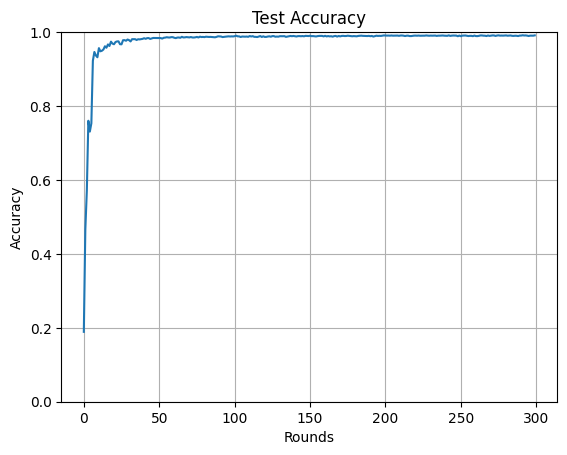

In [16]:
plt.plot(accuracies)
plt.title('Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()